# Social Vulnerability Milan - Calculate Vulnerability

## Environment

### R Libraries
The relvant R libraries are imported in to the kernal:

In [1]:
# Load R libraries
if(!require("pacman"))
    install.packages("pacman")

p_load("sf", "tidyverse")

print("Loaded Packages:")
p_loaded()

Loading required package: pacman



[1] "Loaded Packages:"


[1] "lubridate" "forcats"   "stringr"   "dplyr"     "purrr"     "readr"    
 [7] "tidyr"     "tibble"    "ggplot2"   "tidyverse" "sf"        "pacman"

### Output directory

In [2]:
# create the output directory if it does not exist
output_dir <- file.path("../..","3_outputs","Italy","Milan","2021")
if(!dir.exists(output_dir)){
    dir.create(output_dir, recursive = TRUE)
    print(paste0(output_dir, " created"))
}

### Set the GUID

In [3]:
GUID <- "SEZ2011"

## Load Data

### Import the data

In [4]:
# Load census data
census_indicator_data <- read.csv("../../2_pipeline/Italy/Milan/1a_CensusData/2021/censusDataZ.csv")
colnames(census_indicator_data)[colnames(census_indicator_data) == "GUID"] = "SA_GUID__1"
head(census_indicator_data)

# Load Coperncius data: tree cover density (TCD) and imperviousness density (IMP)
tcd_indicator_data <- st_read("../../2_pipeline/Italy/Milan/1b_Copernicus/2021/census_areas_TCD.geojson")
imd_indicator_data <- st_read("../../2_pipeline/Italy/Milan/1b_Copernicus/2021/census_areas_IMD.geojson")

# Get the geospatial data from the TCS data (the IMD data also has same spatial data)
oa <- subset(tcd_indicator_data, select = c(GUID, 'geometry'))

# Load vulnerability mapping information from the config file
## This mapping information is used to help guide the amalgamation of the data.
## Weighting can be changed in this file, depending on the scenario.
## Scenario 1 (best case scenario): Weighting values 1 or -1:
##  where 1 means no change
##  or -1 means all the indicator values are multiplied by -1, resulting in an inverse indicator.
## Scenario 2: Weighting values 0.5 or -0.5:
##  For domains with just a single indicators or where there is a lack of information related to missing indicators. 
##  For these domains the weights are halved using a weight of 0.5, or -0.5 for an inverse indicator.
##  Therefore the influence of these indicators are reduced in half.
## Other scenarios are supported by using other decimal numbers if decided for a particular dataset.
indicator_mapping <- read.csv("config/vulnerabilityIndicatorMappings.csv", header=TRUE, sep=",", stringsAsFactors = FALSE, fileEncoding="UTF-8-BOM")

# Print up to 100 rows of vulnerabiltiy mapping config file
head(indicator_mapping,100)

SEZ2011    early_childhood_boy early_childhood_girl
1 1.5146e+11 -1.230411           -1.064144           
2 1.5146e+11 -1.230411           -1.064144           
3 1.5146e+11 -1.230411           -1.064144           
4 1.5146e+11 -1.230411           -1.064144           
5 1.5146e+11 -1.230411           -1.064144           
6 1.5146e+11 -1.230411           -1.064144           
  age_middle_to_oldest_old_male age_middle_to_oldest_old_female dependants
1  2.1196292                    -1.3062152                      -0.7801407
2  0.2302043                    -0.3189938                       0.1197864
3  3.8043177                    -1.3062152                      -2.2200240
4  2.6982091                    -1.3062152                      -0.5183437
5 19.6216703                    -1.3062152                      -2.2200240
6 -1.0625601                    -1.3062152                      -2.2200240
  unemployment no_higher_education foreign_nationals primary_school_age
1 -0.5060886   -0.6075338           0.284861877      -1.458348         
2  1.3419462    0.8849880           0.768744204      -1.458348         
3 -0.2425543   -1.6458099          -1.081394102      -1.458348         
4 -1.2391934   -1.6458099          -0.004949997       1.865648         
5 -2.2981224   -1.6458099          -1.081394102      -1.458348         
6 -2.2981224   -1.6458099           2.865567617      -1.458348         
  one_person_households
1  0.9333249           
2 -0.7026211           
3  3.2236494           
4  0.2789465           
5  3.2236494           
6  0.9333249

Reading layer `census_areas_TCD' from data source 
  `/Cities/2_pipeline/Italy/Milan/1b_Copernicus/2021/census_areas_TCD.geojson' 
  using driver `GeoJSON'
Simple feature collection with 6079 features and 15 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1503202 ymin: 5025952 xmax: 1521750 ymax: 5042528
Projected CRS: Monte Mario / Italy zone 1
Reading layer `census_areas_IMD' from data source 
  `/Cities/2_pipeline/Italy/Milan/1b_Copernicus/2021/census_areas_IMD.geojson' 
  using driver `GeoJSON'
Simple feature collection with 6079 features and 15 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1503202 ymin: 5025952 xmax: 1521750 ymax: 5042528
Projected CRS: Monte Mario / Italy zone 1


domain               indicator                       sensitivity prepare
1  age                  early_childhood_boy             1           0      
2  age                  early_childhood_girl            1           0      
3  age                  age_middle_to_oldest_old_male   1           0      
4  age                  age_middle_to_oldest_old_female 1           0      
5  income               dependants                      0           1      
6  income               unemployment                    0           1      
7  info_access_use      no_higher_education             0           1      
8  local_knowledge      foreign_nationals               0           1      
9  social_network       primary_school_age              0           0      
10 social_network       one_person_households           0           0      
11 physical_environment impervious                      0           0      
12 physical_environment tree_cover_density              0           0      
   respond recover adaptive_capacity enhanced_exposure weight
1  0       0       0                 0                  1.0  
2  0       0       0                 0                  1.0  
3  0       0       0                 0                  1.0  
4  0       0       0                 0                  1.0  
5  1       1       1                 0                  1.0  
6  1       1       1                 0                  1.0  
7  1       1       1                 0                  0.5  
8  1       0       1                 0                  0.5  
9  1       1       1                 0                 -1.0  
10 1       1       1                 0                  1.0  
11 0       0       0                 1                  1.0  
12 0       0       0                 1                  1.0

## Prepare Data

### Combine data into a single indicator dataset

In [5]:
# combine census data with copernicus TCD and IMD data (without geospatial data to advoid duplication)
indicator_data <- merge(tcd_indicator_data, st_drop_geometry(census_indicator_data), by.x = GUID, by.y = GUID, all.x = TRUE)
indicator_data <- merge(imd_indicator_data, st_drop_geometry(indicator_data), by=GUID)

# drop the geometry
indicator_data <- st_drop_geometry(indicator_data)

# change the small area id column data type (GUID) to character string
indicator_data[GUID] <- lapply(indicator_data[GUID], as.character)

# trim the columns
indicator_data <- subset(indicator_data, select=c(names(census_indicator_data), 'tree_cover_density', 'impervious'))

# Set missing data fields to zero (0)
# Note: In Italian census the NA or empty data fields are areas with no population (e.g. parks, schools, etc.)
indicator_data[is.na(indicator_data)] <- 0

# Print the first part of the indicators, which are now collated into one table
head(indicator_data)

SEZ2011      early_childhood_boy early_childhood_girl
1 151460000001 -1.230411           -1.064144           
2 151460000002 -1.230411           -1.064144           
3 151460000003 -1.230411           -1.064144           
4 151460000004 -1.230411           -1.064144           
5 151460000005 -1.230411           -1.064144           
6 151460000006  0.000000            0.000000           
  age_middle_to_oldest_old_male age_middle_to_oldest_old_female dependants
1  2.1196292                    -1.3062152                      -0.7801407
2  0.2302043                    -0.3189938                       0.1197864
3  3.8043177                    -1.3062152                      -2.2200240
4  2.6982091                    -1.3062152                      -0.5183437
5 19.6216703                    -1.3062152                      -2.2200240
6  0.0000000                     0.0000000                       0.0000000
  unemployment no_higher_education foreign_nationals primary_school_age
1 -0.5060886   -0.6075338           0.284861877      -1.458348         
2  1.3419462    0.8849880           0.768744204      -1.458348         
3 -0.2425543   -1.6458099          -1.081394102      -1.458348         
4 -1.2391934   -1.6458099          -0.004949997       1.865648         
5 -2.2981224   -1.6458099          -1.081394102      -1.458348         
6  0.0000000    0.0000000           0.000000000       0.000000         
  one_person_households tree_cover_density impervious
1  0.9333249            0.6144226          1.409195  
2 -0.7026211            0.6144226          1.469237  
3  3.2236494            0.6144226          1.057469  
4  0.2789465            0.6144226          1.226182  
5  3.2236494            0.6144226          1.319901  
6  0.0000000            0.6144226          1.484096

### Weight the indicator datas 

In [6]:
# Get the indicator weighting, previously loaded from the config file
indicator_weighting <- indicator_mapping %>% select('indicator', 'weight')
indicator_weighting <- indicator_weighting %>% spread(key = 'indicator', value = 'weight')

# Get the column names and weights
names <- names(indicator_weighting)
weights <- indicator_weighting[, names]

# Copy and rename the dataset
indicator_data_weighted <- indicator_data
head(indicator_data_weighted) 

# Multiply the indicators by the config file weighting
indicator_data_weighted[, names] <- sweep(indicator_data_weighted[, names], 2, unlist(weights[, names]), "*")
head(indicator_data_weighted)

SEZ2011      early_childhood_boy early_childhood_girl
1 151460000001 -1.230411           -1.064144           
2 151460000002 -1.230411           -1.064144           
3 151460000003 -1.230411           -1.064144           
4 151460000004 -1.230411           -1.064144           
5 151460000005 -1.230411           -1.064144           
6 151460000006  0.000000            0.000000           
  age_middle_to_oldest_old_male age_middle_to_oldest_old_female dependants
1  2.1196292                    -1.3062152                      -0.7801407
2  0.2302043                    -0.3189938                       0.1197864
3  3.8043177                    -1.3062152                      -2.2200240
4  2.6982091                    -1.3062152                      -0.5183437
5 19.6216703                    -1.3062152                      -2.2200240
6  0.0000000                     0.0000000                       0.0000000
  unemployment no_higher_education foreign_nationals primary_school_age
1 -0.5060886   -0.6075338           0.284861877      -1.458348         
2  1.3419462    0.8849880           0.768744204      -1.458348         
3 -0.2425543   -1.6458099          -1.081394102      -1.458348         
4 -1.2391934   -1.6458099          -0.004949997       1.865648         
5 -2.2981224   -1.6458099          -1.081394102      -1.458348         
6  0.0000000    0.0000000           0.000000000       0.000000         
  one_person_households tree_cover_density impervious
1  0.9333249            0.6144226          1.409195  
2 -0.7026211            0.6144226          1.469237  
3  3.2236494            0.6144226          1.057469  
4  0.2789465            0.6144226          1.226182  
5  3.2236494            0.6144226          1.319901  
6  0.0000000            0.6144226          1.484096

SEZ2011      early_childhood_boy early_childhood_girl
1 151460000001 -1.230411           -1.064144           
2 151460000002 -1.230411           -1.064144           
3 151460000003 -1.230411           -1.064144           
4 151460000004 -1.230411           -1.064144           
5 151460000005 -1.230411           -1.064144           
6 151460000006  0.000000            0.000000           
  age_middle_to_oldest_old_male age_middle_to_oldest_old_female dependants
1  2.1196292                    -1.3062152                      -0.7801407
2  0.2302043                    -0.3189938                       0.1197864
3  3.8043177                    -1.3062152                      -2.2200240
4  2.6982091                    -1.3062152                      -0.5183437
5 19.6216703                    -1.3062152                      -2.2200240
6  0.0000000                     0.0000000                       0.0000000
  unemployment no_higher_education foreign_nationals primary_school_age
1 -0.5060886   -0.3037669           0.142430939       1.458348         
2  1.3419462    0.4424940           0.384372102       1.458348         
3 -0.2425543   -0.8229049          -0.540697051       1.458348         
4 -1.2391934   -0.8229049          -0.002474999      -1.865648         
5 -2.2981224   -0.8229049          -0.540697051       1.458348         
6  0.0000000    0.0000000           0.000000000       0.000000         
  one_person_households tree_cover_density impervious
1  0.9333249            0.6144226          1.409195  
2 -0.7026211            0.6144226          1.469237  
3  3.2236494            0.6144226          1.057469  
4  0.2789465            0.6144226          1.226182  
5  3.2236494            0.6144226          1.319901  
6  0.0000000            0.6144226          1.484096

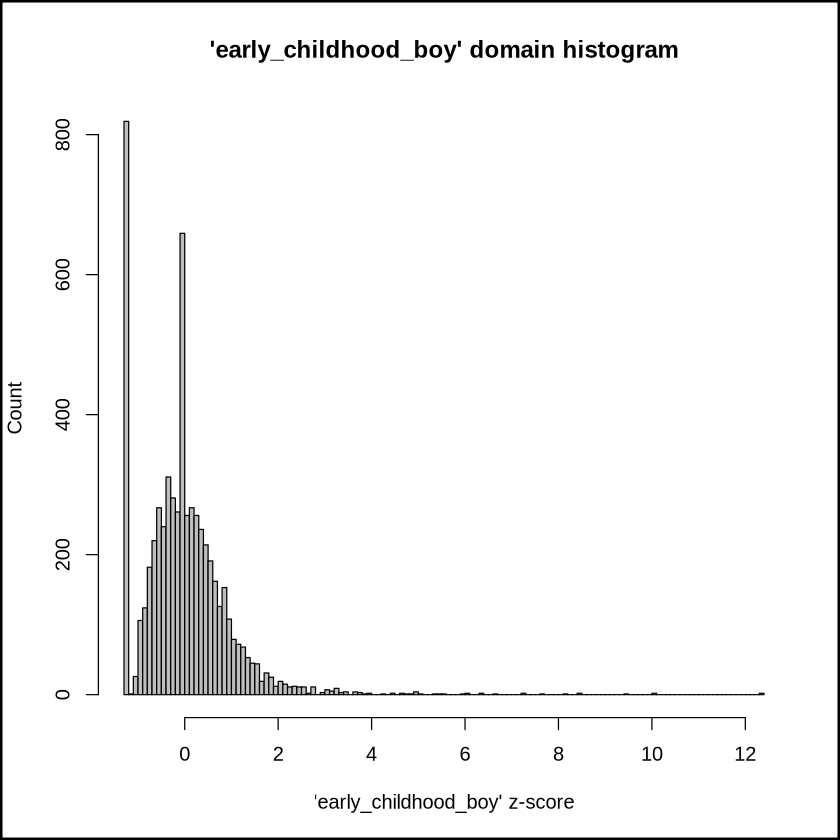

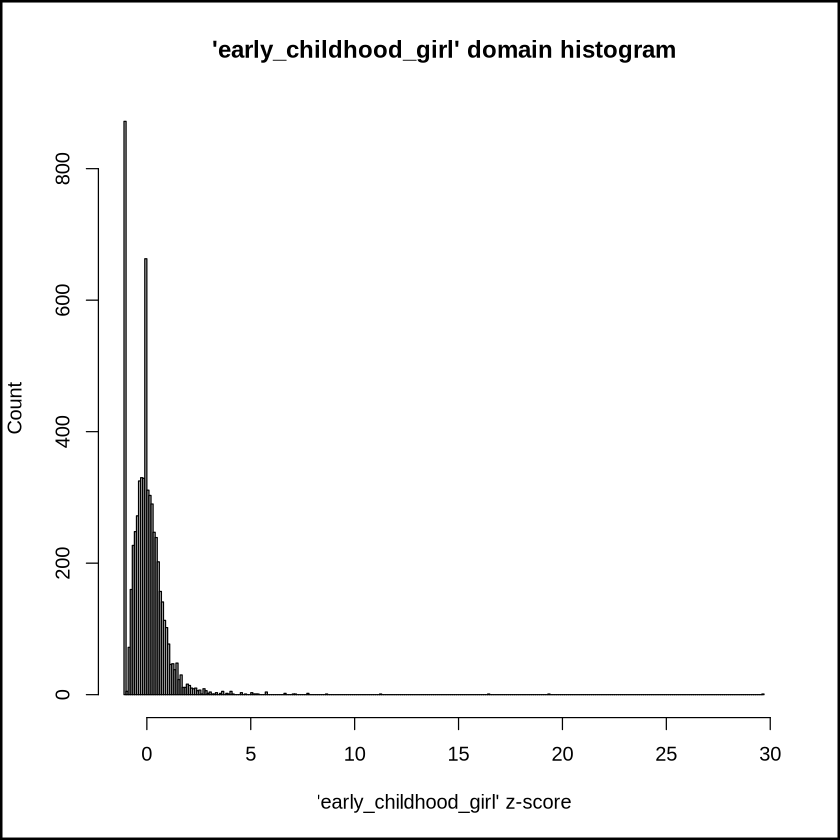

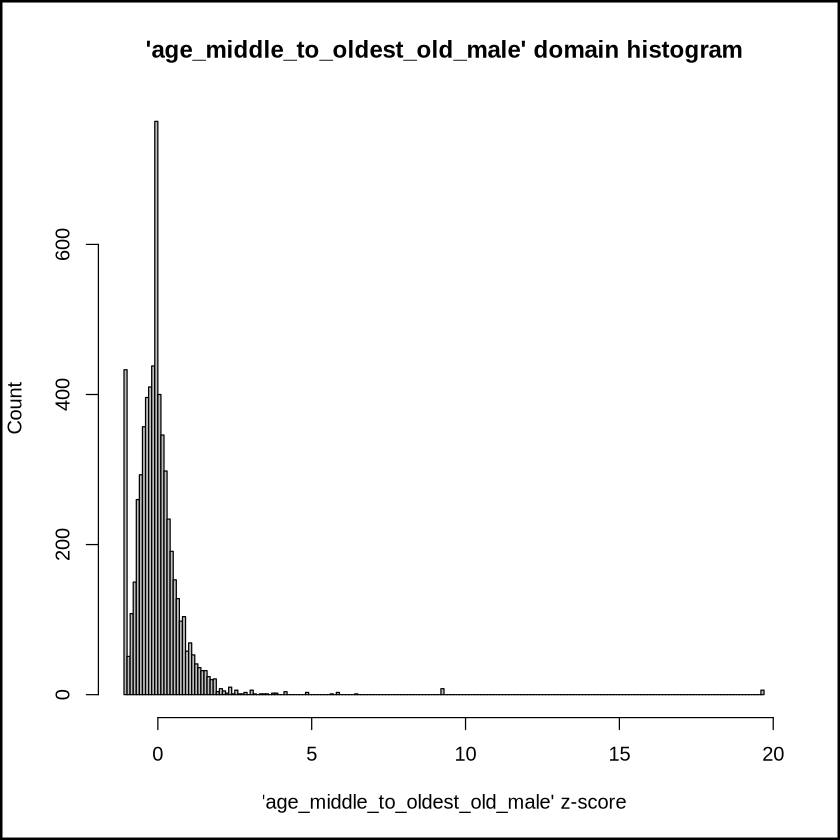

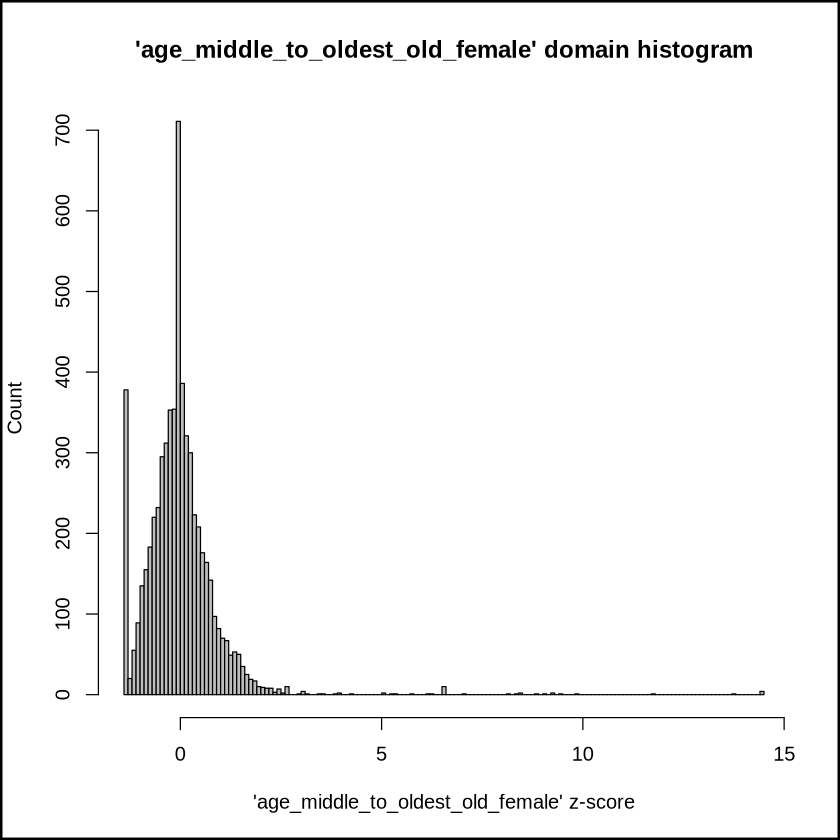

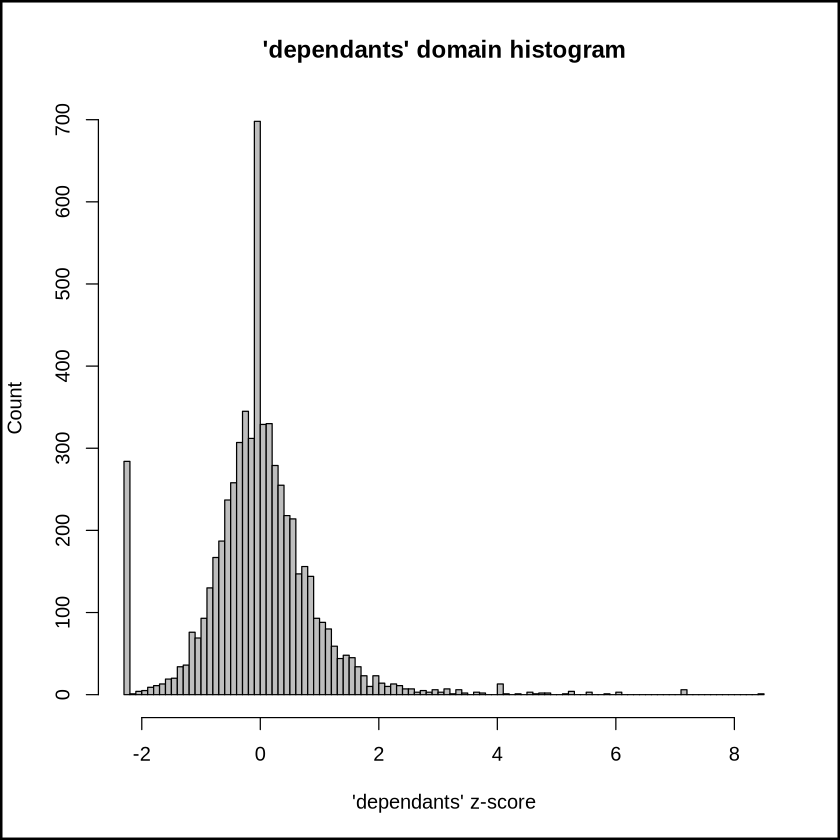

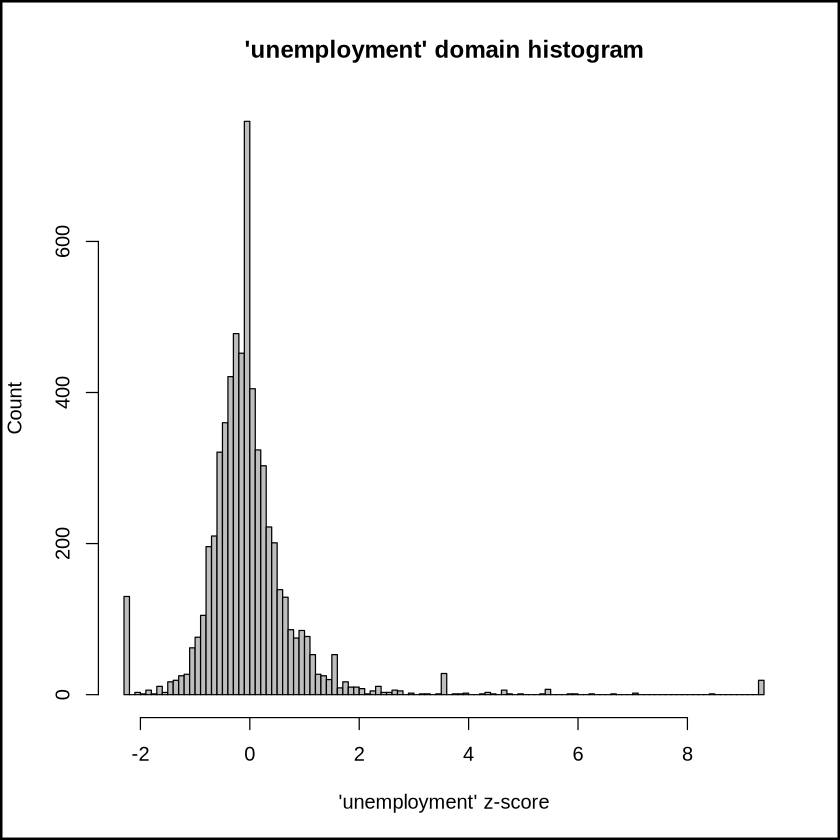

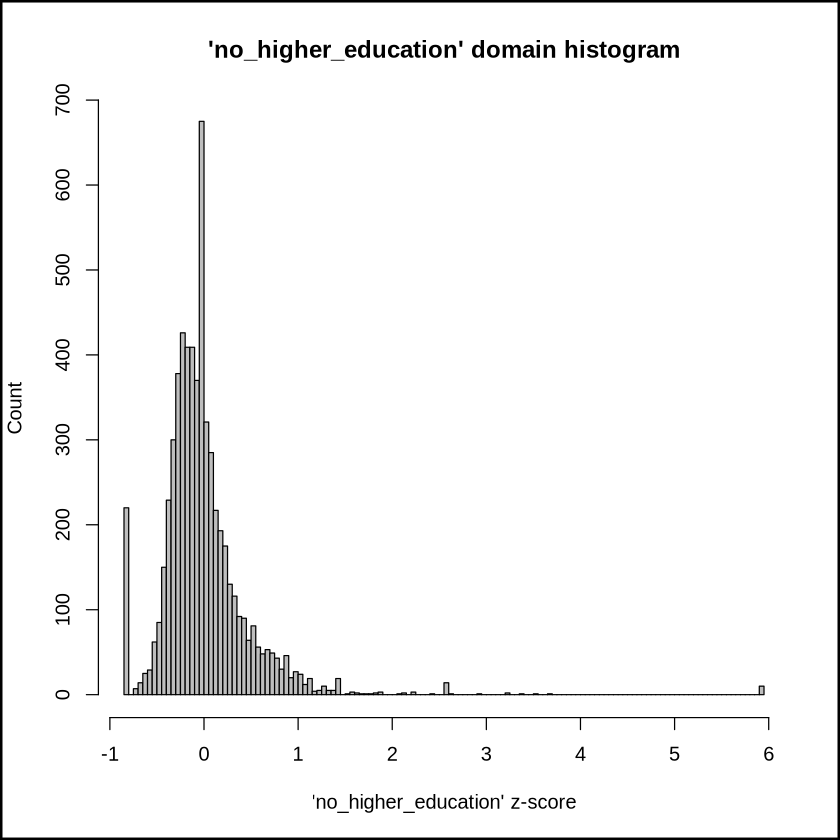

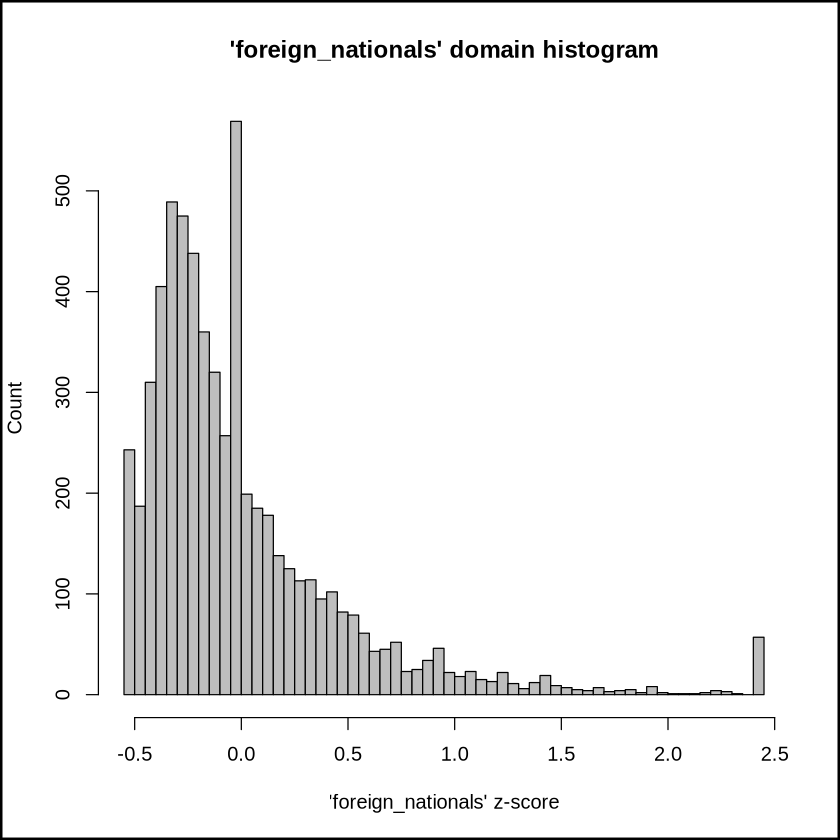

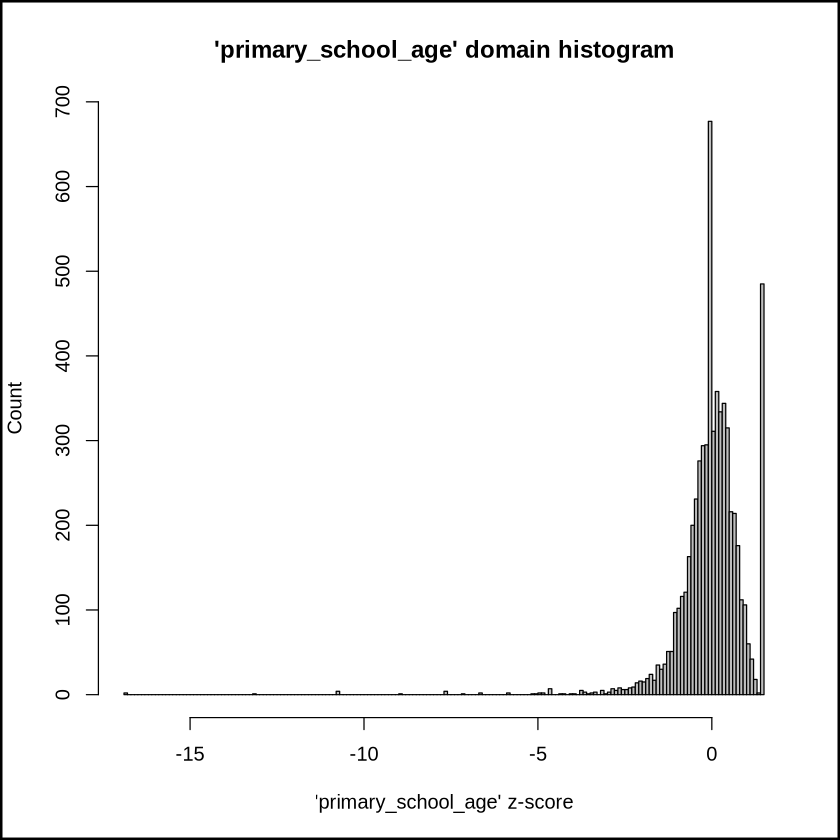

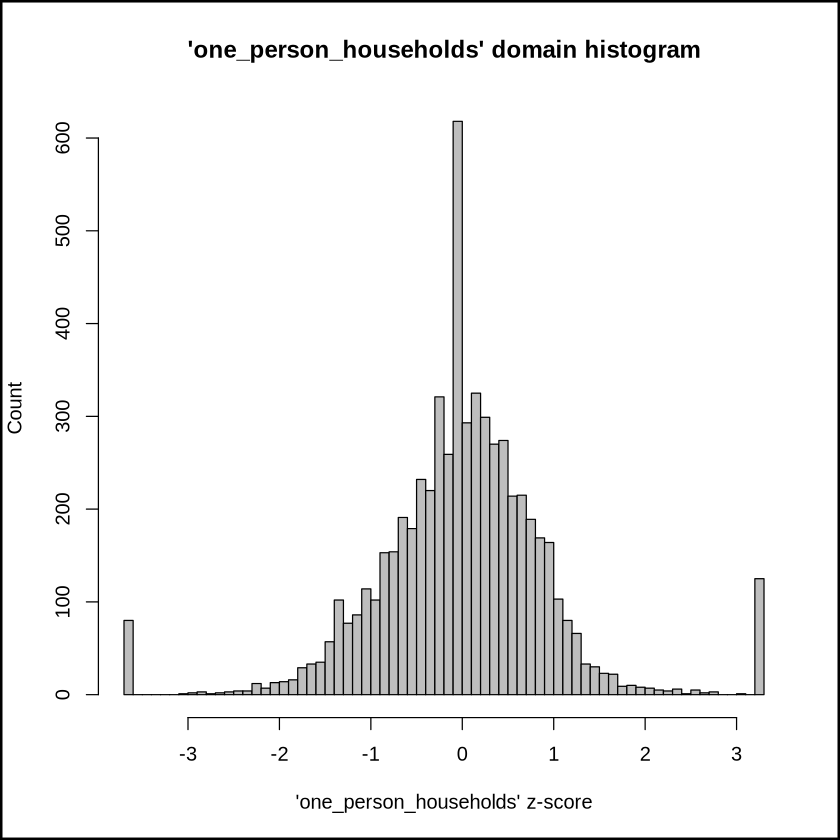

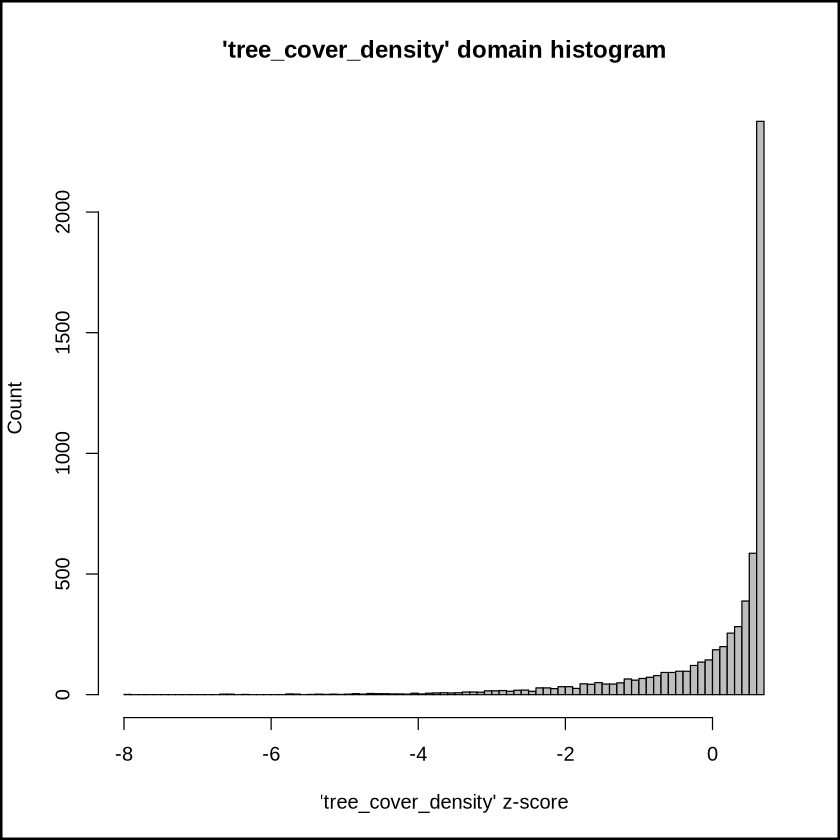

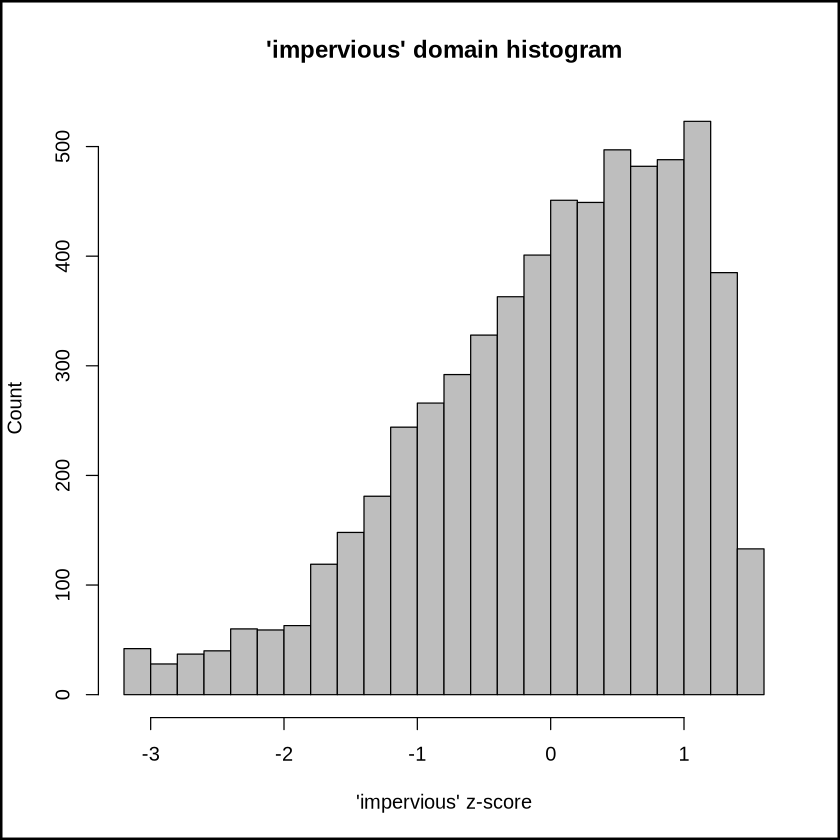

In [7]:
# Histogram visualisation of weighted indicators
indicator_columns <- colnames(indicator_data_weighted)[-1]
for( current_indicator_column in indicator_columns ) {
    indicator_filtered <- indicator_data_weighted[,current_indicator_column] 
    indicator_filtered[indicator_filtered == "NaN"] <- 0

    title <- paste("'", current_indicator_column, "' domain histogram", sep = "")
    x_label <- paste("'", current_indicator_column, "' z-score", sep = "")
    y_label <- paste("Count", sep = "")
    hist(indicator_filtered, breaks="FD", col="grey", labels = FALSE, main=title, xlab=x_label, ylab=y_label)
    box("figure", lwd = 4)
}

## Process social vulnerability scores

### Calculate domain scores

In [8]:
# Get the domains and their associated indicator ID
domain_indicators <- indicator_mapping %>% select('domain', 'indicator')

# Get a vector/array of the unique domain names
unique_domains <- unique(domain_indicators$domain)

# Initialise the domain score dataset with the GUID
domain_scores <- indicator_data_weighted %>% select(all_of(GUID))

# Loop through each domain
for (current_domain in unique_domains) {
    # Identify which indicators are used within this domain (current_domain)
    current_domain_info <- domain_indicators %>% filter(domain == current_domain)

    # Count the number of indicators in this domain
    domain_indicator_count <- length(current_domain_info$indicator)

    # Get a vector/array of the indicators used by this domain, and add the GUID column name
    current_domain_indicators <- current_domain_info$indicator
    current_domain_indicators <- (c(GUID, current_domain_indicators))

    # filter the dataset to only use the indicators in the domain
    current_domain_data <- indicator_data_weighted[current_domain_indicators]

    # Calculate the internal weight distribution for the indicators within this domain,
    # using an equal weight distribution across this domain
    internal_domain_weight <- 1.0 / domain_indicator_count

    # Internally weight the data for this domain
    current_domain_data_weighted <- current_domain_data %>% mutate_if(is.numeric, function(x) {x*internal_domain_weight})

    # Sum each data row to get the total score for the domain
    current_domain_data_weighted[, current_domain] <- rowSums(current_domain_data_weighted[2:(domain_indicator_count+1)], na.rm = TRUE)

    # Add the current domain score to the overall results
    domain_indicator_score <- current_domain_data_weighted %>% select(all_of(GUID), all_of(current_domain))
    domain_scores <- merge(domain_scores, domain_indicator_score, by=GUID)
}

# Print the first part of the domain z-scores, which are now collated into one table
head(domain_scores)

SEZ2011      age         income     info_access_use local_knowledge
1 151460000001 -0.37028523 -0.6431147 -0.3037669       0.142430939   
2 151460000002 -0.59583610  0.7308663  0.4424940       0.384372102   
3 151460000003  0.05088688 -1.2312892 -0.8229049      -0.540697051   
4 151460000004 -0.22564026 -0.8787686 -0.8229049      -0.002474999   
5 151460000005  4.00522505 -2.2590732 -0.8229049      -0.540697051   
6 151460000006  0.00000000  0.0000000  0.0000000       0.000000000   
  social_network physical_environment
1  1.1958366     1.0118090           
2  0.3778636     1.0418299           
3  2.3409988     0.8359458           
4 -0.7933508     0.9203024           
5  2.3409988     0.9671620           
6  0.0000000     1.0492594

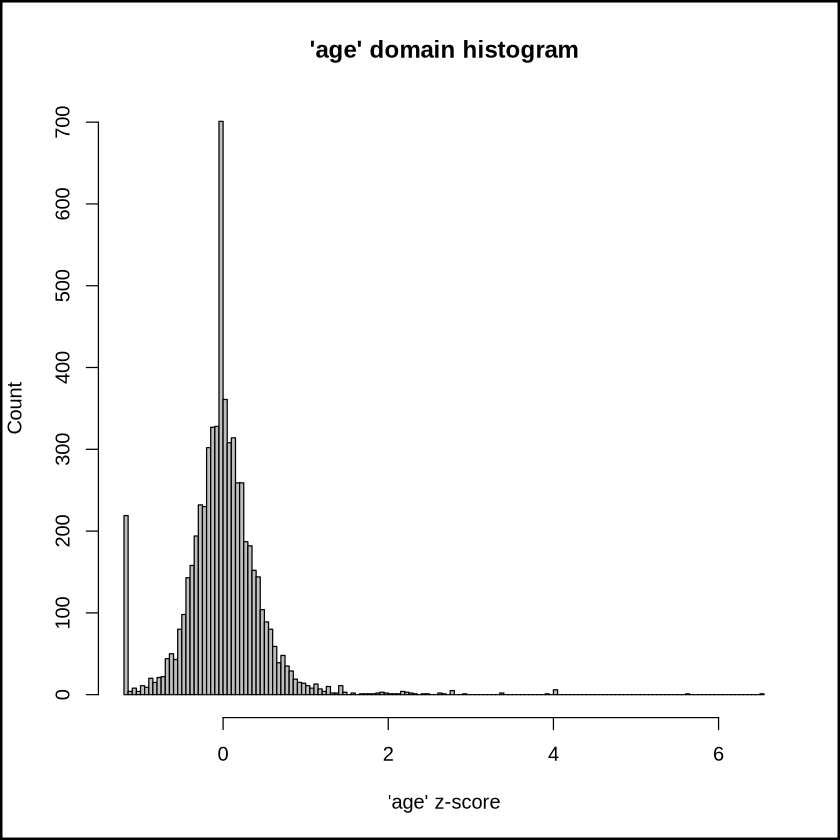

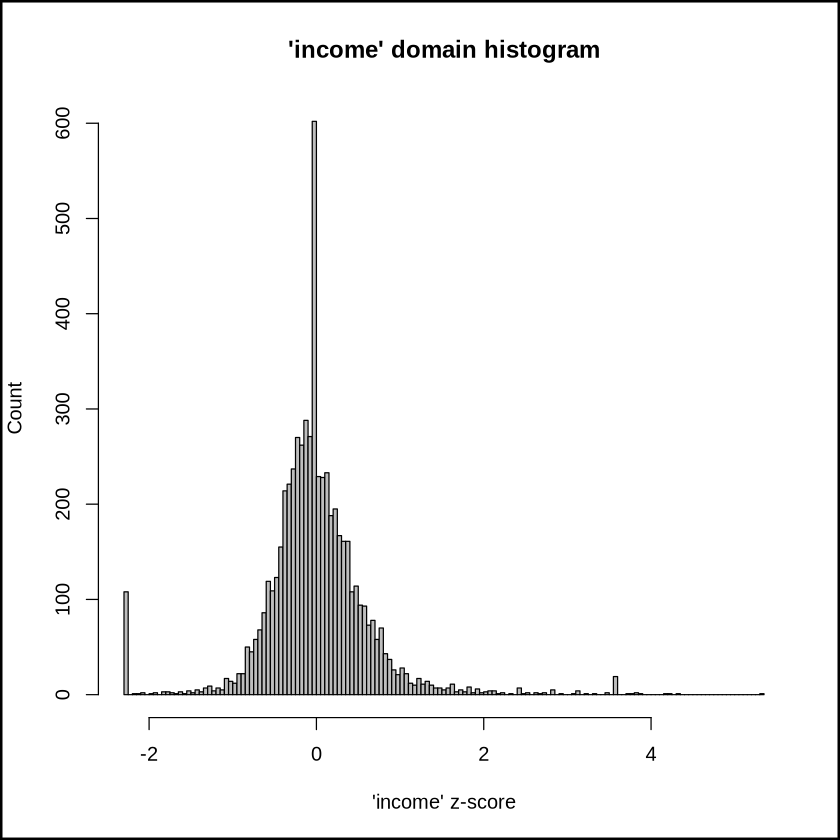

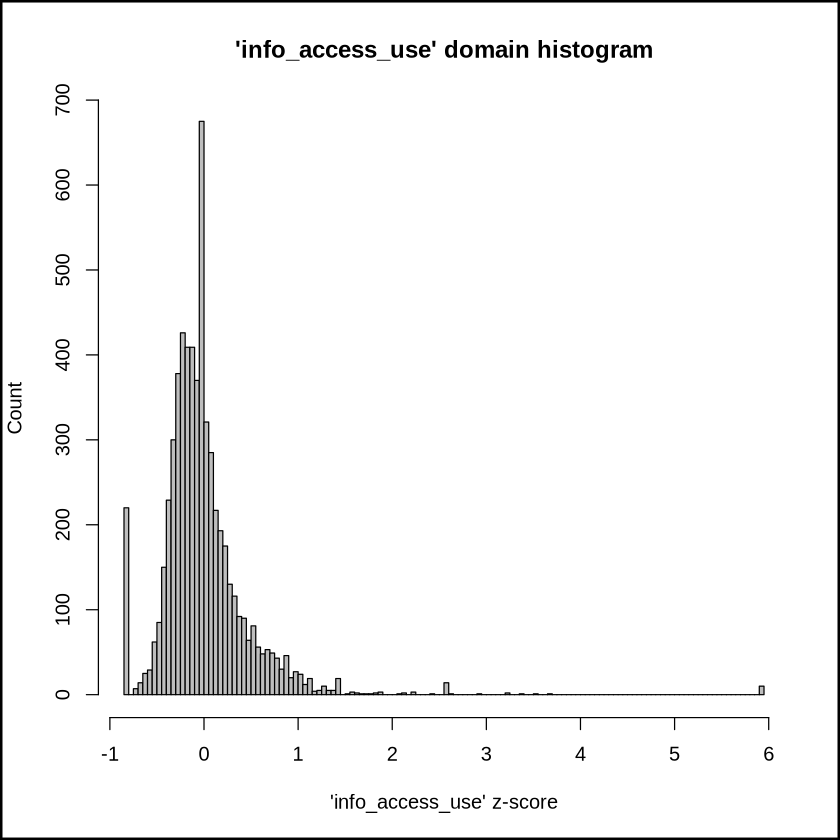

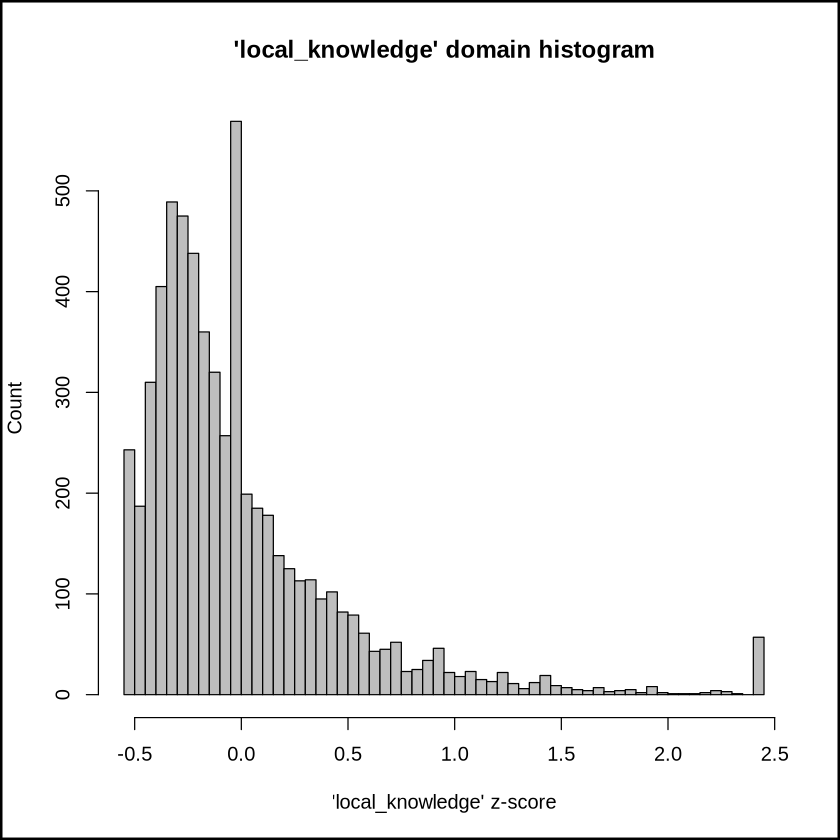

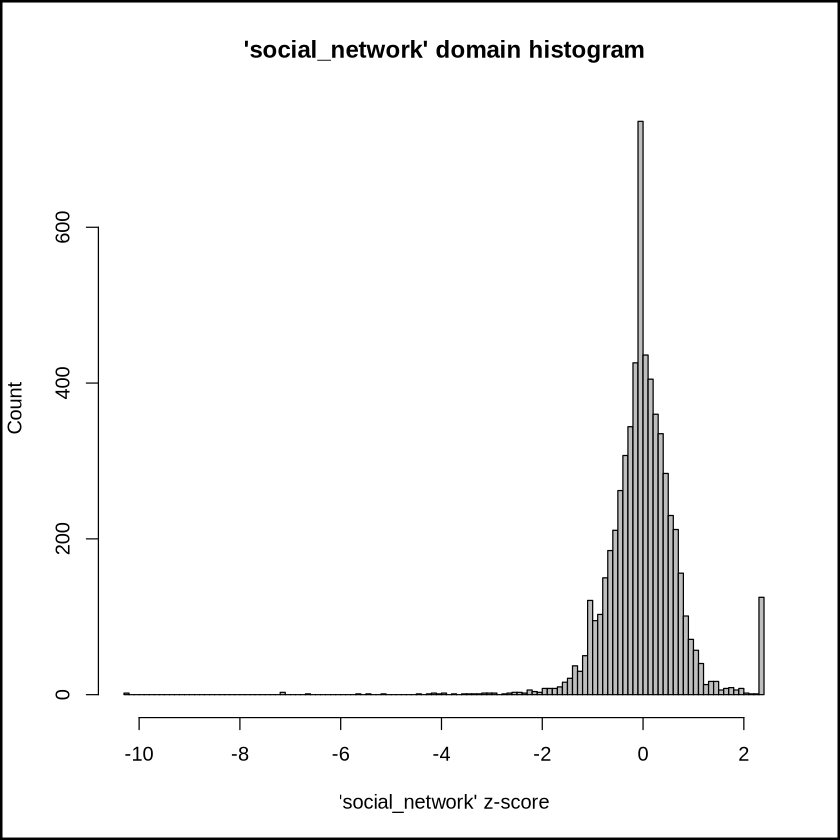

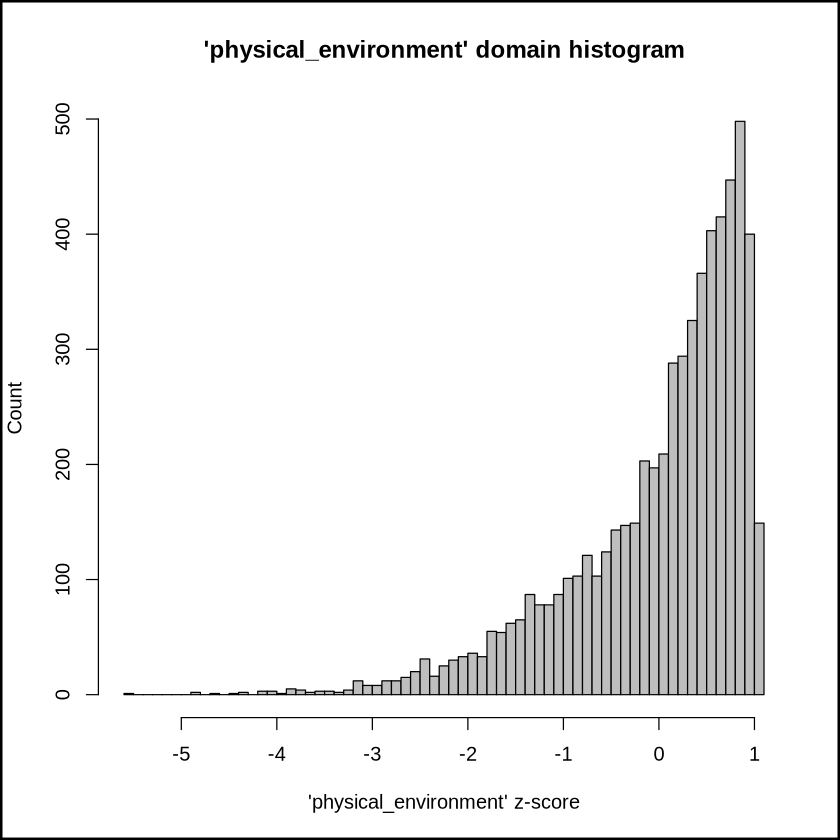

In [9]:
# Histogram visualisation of domain z-scores
for( current_domain in unique_domains ) {
    domain_scores_filtered <- domain_scores[,current_domain] 
    domain_scores_filtered[domain_scores_filtered == "NaN"] <- 0

    title <- paste("'", current_domain, "' domain histogram", sep = "")
    x_label <- paste("'", current_domain, "' z-score", sep = "")
    y_label <- paste("Count", sep = "")
    hist(domain_scores_filtered, breaks="FD", col="grey", labels=FALSE, main=title, xlab=x_label, ylab=y_label)
    box("figure", lwd = 4)
}

### Calculate dimension scores
Need to collate the domains into the dimensions

In [10]:
# Create a vector/array of the dimension names
dimensions <- c('sensitivity', 'prepare', 'respond', 'recover', 'adaptive_capacity', 'enhanced_exposure')

# Get the dimension and their associated indicator ID
dimension_indicators <- indicator_mapping %>% select(c('domain', all_of(dimensions)))
head(dimension_indicators)

# Initialise the dimensions score dataset with the GUID
dimension_scores <- indicator_data_weighted %>% select(all_of(GUID))

# loop through each of the dimensions and:
for (current_dimension in dimensions){
    # Identify which indicators are used within this dimension (current_dimension)
    # Then select the indicators marked with value 1, which means that the indicator is part of the dimension
    current_dimension_info <- dimension_indicators %>% select(c('domain', all_of(current_dimension)))
    current_dimension_info <- current_dimension_info %>% filter(dimension_indicators[, current_dimension] == 1)

    # Get a array/vector of the unique domains in this dimension
    current_dimension_domains <- unique(current_dimension_info$domain)

    # Count the number of domains in this dimension
    dimension_domain_count <- length(current_dimension_domains)

    # Filter the domain scores dataset to only use the domains in the dimension, and add the GUID column name
    current_dimension_data <- domain_scores %>% select(c(all_of(GUID), all_of(current_dimension_domains)))  

    # Sum each data row to get the total score for the dimension
    current_dimension_data[, current_dimension] <- rowSums(current_dimension_data[2:(dimension_domain_count+1)], na.rm = TRUE)

    # Add the current dimension score to the overall results
    dimension_indicator_score <- current_dimension_data %>% select(all_of(GUID), all_of(current_dimension))
    dimension_scores <- merge(dimension_scores, dimension_indicator_score, by=GUID)  
}

# generate z-scores with the scale function in order to standardise the dimension data
dimension_scores <- dimension_scores %>% mutate_if(is.numeric, scale)

# Print the first part of the dimension scores, which are now collated into one table
head(dimension_scores)

domain sensitivity prepare respond recover adaptive_capacity
1 age    1           0       0       0       0                
2 age    1           0       0       0       0                
3 age    1           0       0       0       0                
4 age    1           0       0       0       0                
5 income 0           1       1       1       1                
6 income 0           1       1       1       1                
  enhanced_exposure
1 0                
2 0                
3 0                
4 0                
5 0                
6 0

SEZ2011      sensitivity   prepare      respond      recover     
1 151460000001 -0.7647853635 -0.696485479  0.320951976  0.271253971
2 151460000002 -1.2304165745  1.355476641  1.575888423  1.676990485
3 151460000003  0.1046897905 -2.251790899 -0.203447695  0.312110916
4 151460000004 -0.4661777348 -1.478027752 -2.026764566 -2.690739562
5 151460000005  8.2680954025 -3.144598085 -1.038699169 -0.797332495
6 151460000006 -0.0003619911  0.002318221  0.002883523  0.002519028
  adaptive_capacity enhanced_exposure
1  0.320951976      1.0934219        
2  1.575888423      1.1258642        
3 -0.203447695      0.9033735        
4 -2.026764566      0.9945343        
5 -1.038699169      1.0451736        
6  0.002883523      1.1338930

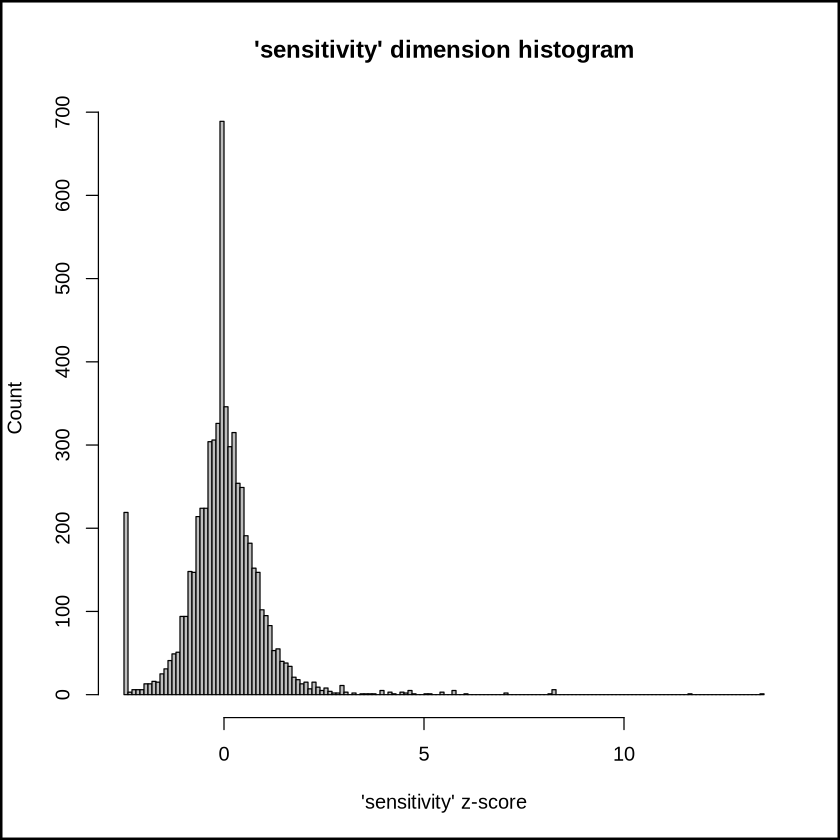

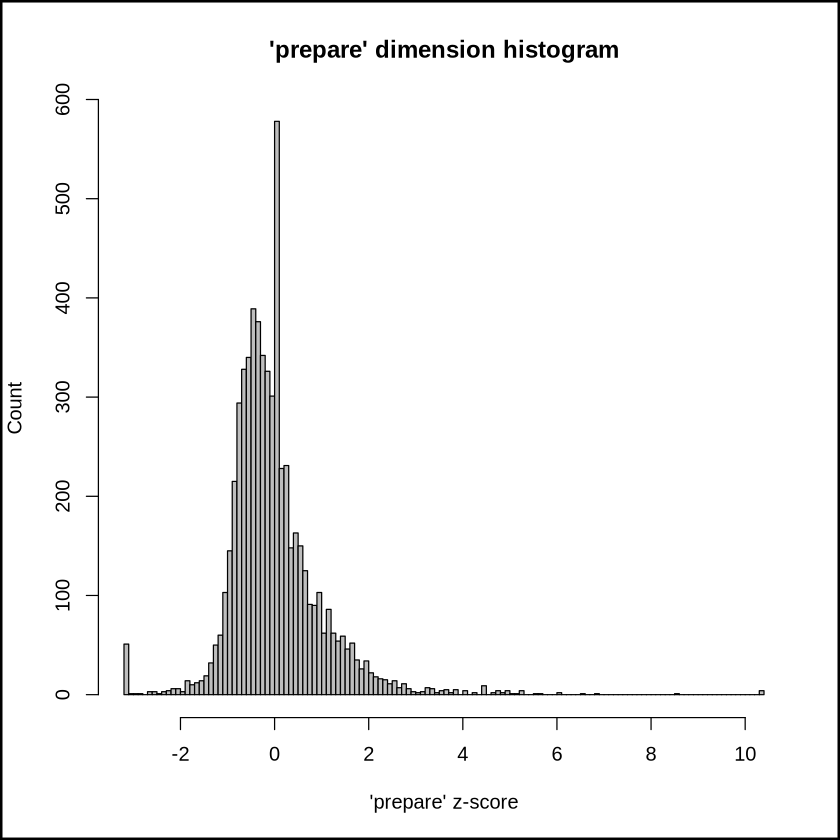

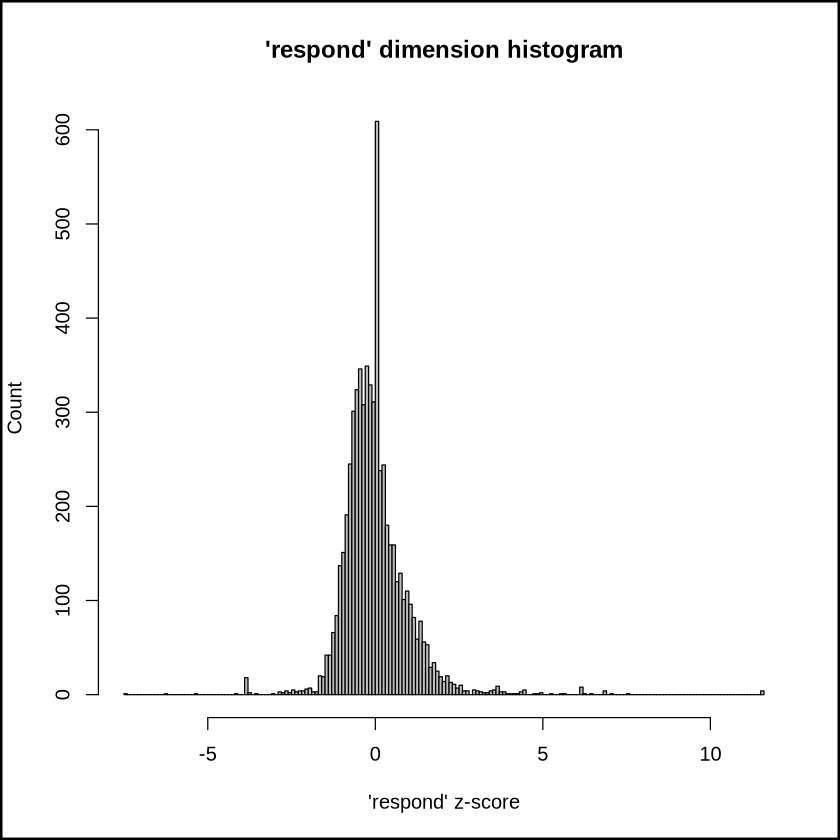

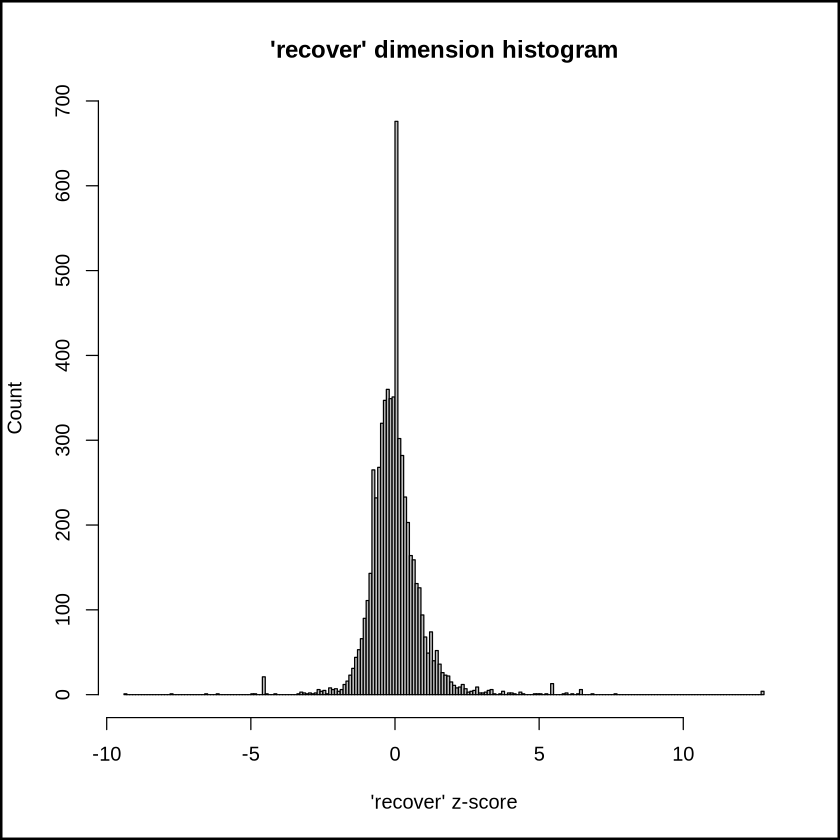

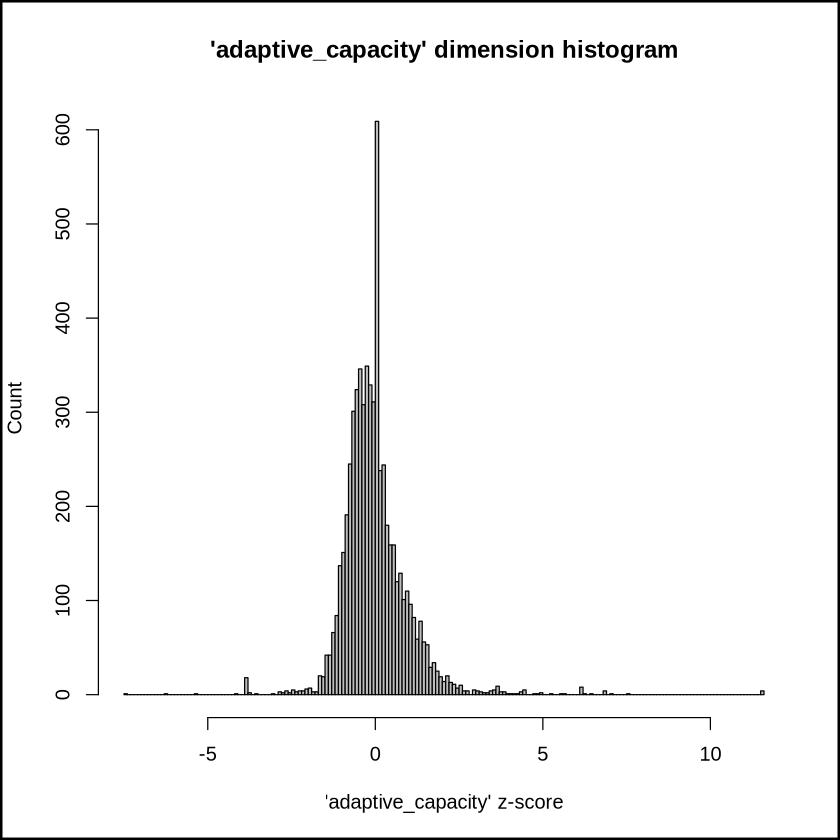

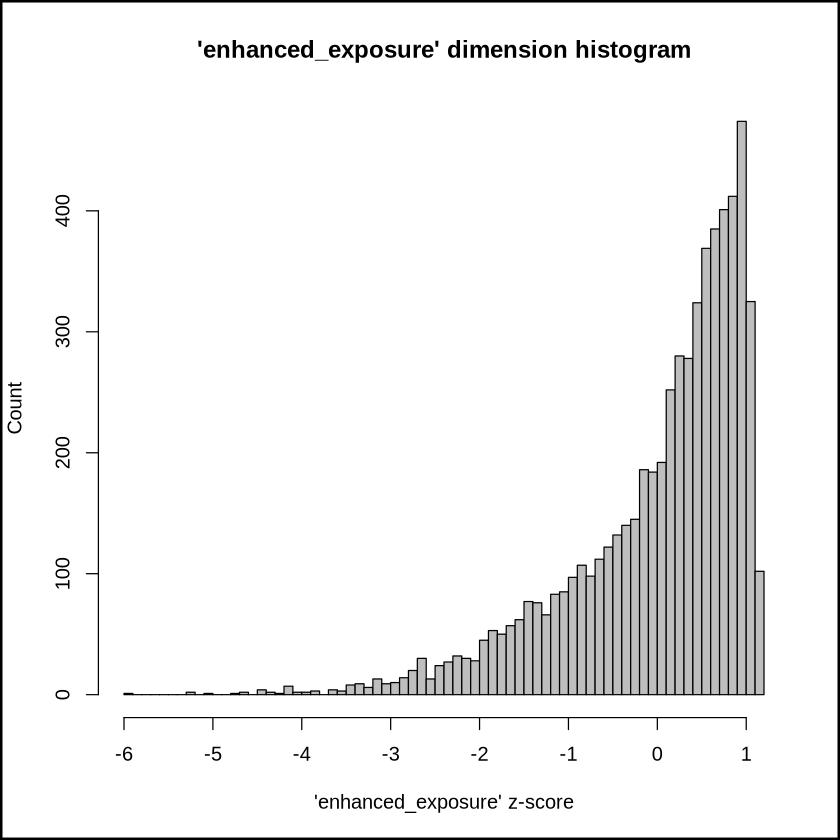

In [11]:
# Histogram visualisation of dimension z-scores
for( current_dimension in dimensions ){
    dimension_scores_filtered <- dimension_scores[,current_dimension] 
    dimension_scores_filtered[dimension_scores_filtered == "NaN"] <- 0
   
    title <- paste("'", current_dimension, "' dimension histogram", sep = "")
    x_label <- paste("'", current_dimension, "' z-score", sep = "")
    y_label <- paste("Count", sep = "")
    hist(dimension_scores_filtered, breaks="FD", col="grey", labels=FALSE, main=title, xlab=x_label, ylab=y_label)
    box("figure", lwd = 4)
}

## Calculate vulnerability score

In [12]:
# Initialise the vulnerability score dataset with the GUID
vulnerability_scores <- domain_scores %>% select(all_of(GUID))

#sum the domains to create a total overall score of vulnerability
vulnerability_scores$social_vulnerability <- rowSums(domain_scores[2:(ncol(domain_scores))], na.rm = TRUE)

# generate z-scores with the scale function in order to standardise the vulnerability data
vulnerability_scores <- vulnerability_scores %>% mutate_if(is.numeric, scale)

# Print the first part of the vulnerability scores, which are now collated into one table
head(vulnerability_scores)

SEZ2011      social_vulnerability
1 151460000001  0.6558794          
2 151460000002  1.5094801          
3 151460000003  0.4027326          
4 151460000004 -1.1389091          
5 151460000005  2.3380431          
6 151460000006  0.6662274

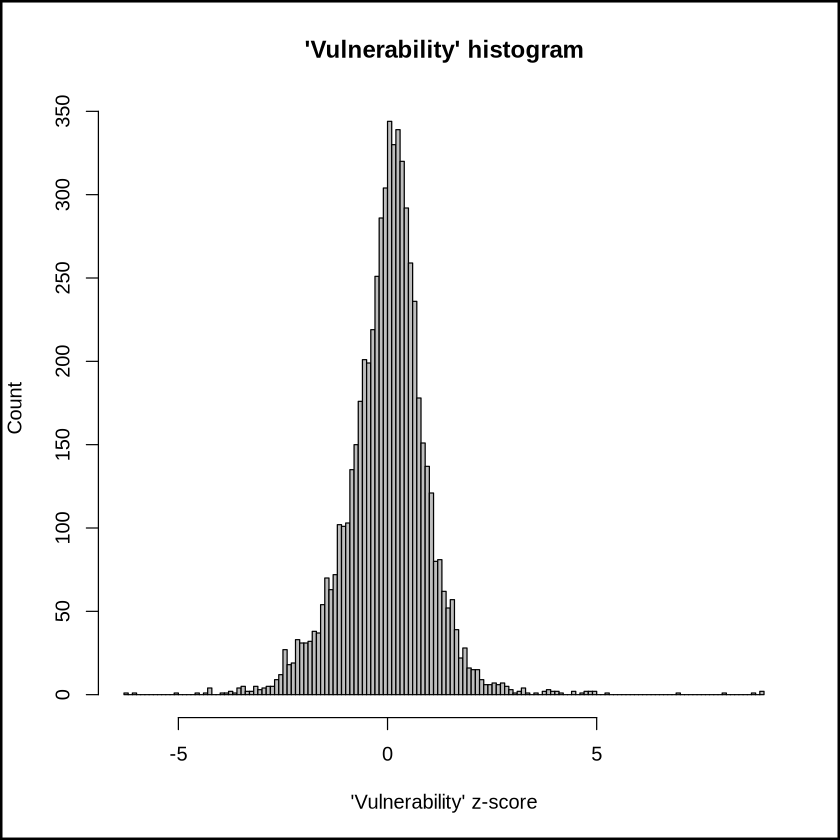

In [13]:
# Histogram visualisation of Vulnerability z-scores
title <- paste("'Vulnerability' histogram", sep = "")
x_label <- paste("'Vulnerability' z-score", sep = "")
y_label <- paste("Count", sep = "")
hist(vulnerability_scores$social_vulnerability, breaks="FD", col="grey", labels=FALSE, main=title, xlab=x_label, ylab=y_label)
box("figure", lwd = 4)

In [14]:
# Merge all the indicators, domains, dimensions, and total vulnerability into one dataset
output_dataset <- merge(indicator_data_weighted, domain_scores, by=GUID)
output_dataset <- merge(output_dataset, dimension_scores, by=GUID)
output_dataset <- merge(output_dataset, vulnerability_scores, by=GUID)

head(output_dataset)

SEZ2011      early_childhood_boy early_childhood_girl
1 151460000001 -1.230411           -1.064144           
2 151460000002 -1.230411           -1.064144           
3 151460000003 -1.230411           -1.064144           
4 151460000004 -1.230411           -1.064144           
5 151460000005 -1.230411           -1.064144           
6 151460000006  0.000000            0.000000           
  age_middle_to_oldest_old_male age_middle_to_oldest_old_female dependants
1  2.1196292                    -1.3062152                      -0.7801407
2  0.2302043                    -0.3189938                       0.1197864
3  3.8043177                    -1.3062152                      -2.2200240
4  2.6982091                    -1.3062152                      -0.5183437
5 19.6216703                    -1.3062152                      -2.2200240
6  0.0000000                     0.0000000                       0.0000000
  unemployment no_higher_education foreign_nationals primary_school_age ⋯
1 -0.5060886   -0.3037669           0.142430939       1.458348          ⋯
2  1.3419462    0.4424940           0.384372102       1.458348          ⋯
3 -0.2425543   -0.8229049          -0.540697051       1.458348          ⋯
4 -1.2391934   -0.8229049          -0.002474999      -1.865648          ⋯
5 -2.2981224   -0.8229049          -0.540697051       1.458348          ⋯
6  0.0000000    0.0000000           0.000000000       0.000000          ⋯
  local_knowledge social_network physical_environment sensitivity  
1  0.142430939     1.1958366     1.0118090            -0.7647853635
2  0.384372102     0.3778636     1.0418299            -1.2304165745
3 -0.540697051     2.3409988     0.8359458             0.1046897905
4 -0.002474999    -0.7933508     0.9203024            -0.4661777348
5 -0.540697051     2.3409988     0.9671620             8.2680954025
6  0.000000000     0.0000000     1.0492594            -0.0003619911
  prepare      respond      recover      adaptive_capacity enhanced_exposure
1 -0.696485479  0.320951976  0.271253971  0.320951976      1.0934219        
2  1.355476641  1.575888423  1.676990485  1.575888423      1.1258642        
3 -2.251790899 -0.203447695  0.312110916 -0.203447695      0.9033735        
4 -1.478027752 -2.026764566 -2.690739562 -2.026764566      0.9945343        
5 -3.144598085 -1.038699169 -0.797332495 -1.038699169      1.0451736        
6  0.002318221  0.002883523  0.002519028  0.002883523      1.1338930        
  social_vulnerability
1  0.6558794          
2  1.5094801          
3  0.4027326          
4 -1.1389091          
5  2.3380431          
6  0.6662274

## Correlations

In [15]:
# check the correlations
correlation <- cor(output_dataset %>% select(-c(all_of(GUID))), use="pairwise.complete.obs")
correlation

early_childhood_boy early_childhood_girl
early_childhood_boy              1.00000000          0.229097528        
early_childhood_girl             0.22909753          1.000000000        
age_middle_to_oldest_old_male   -0.14133786         -0.122337104        
age_middle_to_oldest_old_female -0.15237151         -0.115415283        
dependants                       0.47938186          0.447880059        
unemployment                    -0.06813950         -0.099832433        
no_higher_education             -0.05906216         -0.075416063        
foreign_nationals                0.06968821          0.022518991        
primary_school_age              -0.21154109         -0.131044555        
one_person_households           -0.05314040         -0.087782855        
tree_cover_density               0.04948625          0.013555773        
impervious                       0.02815641          0.008966105        
age                              0.46896590          0.497075108        
income                           0.30405399          0.257398729        
info_access_use                 -0.05906216         -0.075416063        
local_knowledge                  0.06968821          0.022518991        
social_network                  -0.17126794         -0.141493083        
physical_environment             0.04195267          0.012169251        
sensitivity                      0.46896590          0.497075108        
prepare                          0.17799654          0.124612566        
respond                          0.06209890          0.030310255        
recover                          0.04605317          0.028487985        
adaptive_capacity                0.06209890          0.030310255        
enhanced_exposure                0.04195267          0.012169251        
social_vulnerability             0.21671079          0.183127935        
                                age_middle_to_oldest_old_male
early_childhood_boy             -0.14133786                  
early_childhood_girl            -0.12233710                  
age_middle_to_oldest_old_male    1.00000000                  
age_middle_to_oldest_old_female  0.29192677                  
dependants                      -0.21914220                  
unemployment                    -0.20364703                  
no_higher_education              0.01344422                  
foreign_nationals               -0.22114688                  
primary_school_age               0.15673150                  
one_person_households           -0.05813362                  
tree_cover_density              -0.11879223                  
impervious                      -0.12314844                  
age                              0.51545437                  
income                          -0.31214939                  
info_access_use                  0.01344422                  
local_knowledge                 -0.22114688                  
social_network                   0.06398469                  
physical_environment            -0.13072785                  
sensitivity                      0.51545437                  
prepare                         -0.26558809                  
respond                         -0.20945491                  
recover                         -0.16260366                  
adaptive_capacity               -0.20945491                  
enhanced_exposure               -0.13072785                  
social_vulnerability            -0.08165958                  
                                age_middle_to_oldest_old_female dependants  
early_childhood_boy             -0.152371506                     0.479381856
early_childhood_girl            -0.115415283                     0.447880059
age_middle_to_oldest_old_male    0.291926773                    -0.219142202
age_middle_to_oldest_old_female  1.000000000                    -0.235062655
dependants                      -0.235062655                     1.000000000
unemployment                    -0.231295057                

## Add geometry

In [16]:
# add st_drop_geometry
output_dataset_geom <- merge(output_dataset, oa, by.x=GUID, by.y=GUID, all.x = TRUE)
head(output_dataset_geom)

SEZ2011      early_childhood_boy early_childhood_girl
1 151460000001 -1.230411           -1.064144           
2 151460000002 -1.230411           -1.064144           
3 151460000003 -1.230411           -1.064144           
4 151460000004 -1.230411           -1.064144           
5 151460000005 -1.230411           -1.064144           
6 151460000006  0.000000            0.000000           
  age_middle_to_oldest_old_male age_middle_to_oldest_old_female dependants
1  2.1196292                    -1.3062152                      -0.7801407
2  0.2302043                    -0.3189938                       0.1197864
3  3.8043177                    -1.3062152                      -2.2200240
4  2.6982091                    -1.3062152                      -0.5183437
5 19.6216703                    -1.3062152                      -2.2200240
6  0.0000000                     0.0000000                       0.0000000
  unemployment no_higher_education foreign_nationals primary_school_age ⋯
1 -0.5060886   -0.3037669           0.142430939       1.458348          ⋯
2  1.3419462    0.4424940           0.384372102       1.458348          ⋯
3 -0.2425543   -0.8229049          -0.540697051       1.458348          ⋯
4 -1.2391934   -0.8229049          -0.002474999      -1.865648          ⋯
5 -2.2981224   -0.8229049          -0.540697051       1.458348          ⋯
6  0.0000000    0.0000000           0.000000000       0.000000          ⋯
  social_network physical_environment sensitivity   prepare      respond     
1  1.1958366     1.0118090            -0.7647853635 -0.696485479  0.320951976
2  0.3778636     1.0418299            -1.2304165745  1.355476641  1.575888423
3  2.3409988     0.8359458             0.1046897905 -2.251790899 -0.203447695
4 -0.7933508     0.9203024            -0.4661777348 -1.478027752 -2.026764566
5  2.3409988     0.9671620             8.2680954025 -3.144598085 -1.038699169
6  0.0000000     1.0492594            -0.0003619911  0.002318221  0.002883523
  recover      adaptive_capacity enhanced_exposure social_vulnerability
1  0.271253971  0.320951976      1.0934219          0.6558794          
2  1.676990485  1.575888423      1.1258642          1.5094801          
3  0.312110916 -0.203447695      0.9033735          0.4027326          
4 -2.690739562 -2.026764566      0.9945343         -1.1389091          
5 -0.797332495 -1.038699169      1.0451736          2.3380431          
6  0.002519028  0.002883523      1.1338930          0.6662274          
  geometry                      
1 POLYGON ((1515164 5034507, ...
2 POLYGON ((1515138 5034525, ...
3 POLYGON ((1515050 5034427, ...
4 POLYGON ((1515095 5034409, ...
5 POLYGON ((1514881 5034455, ...
6 POLYGON ((1514764 5034456, ...

# Export

In [17]:
# CSV
write.csv(output_dataset, file.path(output_dir, "social_vulnerability_index_milan_2021.csv"), row.names = FALSE)

# GeoJSON
st_write(output_dataset_geom, file.path(output_dir, "social_vulnerability_index_milan_2021.geojson"), delete_dsn=TRUE)

# Shapefile
# Need to manually rename these fields, otherwise we get a shapefile creation error
names(output_dataset_geom)[names(output_dataset_geom) == 'early_childhood_boy'] <- 'erly_cld_b'
names(output_dataset_geom)[names(output_dataset_geom) == 'early_childhood_girl'] <- 'erly_cld_g'
names(output_dataset_geom)[names(output_dataset_geom) == 'age_middle_to_oldest_old_male'] <- 'age_old_m'
names(output_dataset_geom)[names(output_dataset_geom) == 'age_middle_to_oldest_old_female'] <- 'age_old_f'
st_write(output_dataset_geom, file.path(output_dir, "social_vulnerability_index_milan_2021.shp"), append = FALSE)

Deleting source `../../3_outputs/Italy/Milan/2021/social_vulnerability_index_milan_2021.geojson' using driver `GeoJSON'
Writing layer `social_vulnerability_index_milan_2021' to data source 
  `../../3_outputs/Italy/Milan/2021/social_vulnerability_index_milan_2021.geojson' using driver `GeoJSON'
Writing 6079 features with 26 fields and geometry type Polygon.


Warning message in abbreviate_shapefile_names(obj):
“Field names abbreviated for ESRI Shapefile driver”


Deleting layer `social_vulnerability_index_milan_2021' using driver `ESRI Shapefile'
Writing layer `social_vulnerability_index_milan_2021' to data source 
  `../../3_outputs/Italy/Milan/2021/social_vulnerability_index_milan_2021.shp' using driver `ESRI Shapefile'
Writing 6079 features with 26 fields and geometry type Polygon.


**END**